In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2


In [2]:
def clahe(image, clip_limit, tile_size):
  # Convert the image to float32 and normalize it to [0, 1]
  image = image.astype(np.float32) / 255.0

  # Get the shape and size of the image
  height, width = image.shape
  image_size = height * width

  # Compute the number of tiles in each dimension
  num_tiles_x = int(np.ceil(width / tile_size))
  num_tiles_y = int(np.ceil(height / tile_size))

  # Pad the image if necessary to make it divisible by the tile size
  pad_x = (num_tiles_x * tile_size) - width
  pad_y = (num_tiles_y * tile_size) - height
  image = np.pad(image, ((0, pad_y), (0, pad_x)), mode="reflect")

  # Create an empty array for the output image
  output = np.zeros_like(image)

  # Loop over the tiles
  for i in range(num_tiles_x):
    for j in range(num_tiles_y):
      # Get the coordinates of the current tile
      x1 = i * tile_size
      x2 = (i + 1) * tile_size
      y1 = j * tile_size
      y2 = (j + 1) * tile_size

      # Get the tile data
      tile = image[y1:y2, x1:x2]

      # Compute the histogram and the cumulative distribution function of the tile
      hist, bins = np.histogram(tile.flatten(), bins=256, range=(0, 1))
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1] # Normalize the cdf to [0, 1]

      # Apply the clip limit to the histogram
      clip_value = clip_limit * hist.max()
      excess = hist - clip_value
      excess = excess[excess > 0].sum()

      # Redistribute the excess pixels uniformly
      hist = np.clip(hist, 0, clip_value)
      step = excess / 256
      hist = hist + step

      # Recompute the cdf after clipping
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1]

      # Interpolate the cdf values for the tile pixels
      tile = np.interp(tile.flatten(), bins[:-1], cdf)

      # Reshape the tile and store it in the output image
      tile = tile.reshape((tile_size, tile_size))
      output[y1:y2, x1:x2] = tile

  # Crop the output image to the original size
  output = output[:height, :width]

  # Convert the output image to uint8 and scale it to [0, 255]
  output = (output * 255).astype(np.uint8)

  # Return the output image
  return output


In [3]:
def clip_histogram(histogram, clip_limit):
    """
    Clip the histogram based on the specified clip_limit.
    """
    clipped_histogram = np.minimum(histogram, clip_limit)
    excess = np.sum(histogram) - np.sum(clipped_histogram)
    num_bins = len(histogram)
    average_bin_increment = excess / num_bins
    clipped_histogram=clipped_histogram.astype(np.float64)
    clipped_histogram += average_bin_increment.astype(np.float64)
    return clipped_histogram



In [4]:
def compute_cumulative_histogram(image):
    """
    Compute the cumulative histogram for a given image.
    """
    histogram, _ = np.histogram(image.flatten(), bins=255, range=[0, 255])
    cumulative_histogram = np.cumsum(histogram)
    return cumulative_histogram

In [5]:
def adaptive_histogram_equalization(image, window_size=10, clip_limit=5.0):
    """
    Apply adaptive histogram equalization to the given image.
    """
    if len(image.shape) == 3:
        # Convert to grayscale if the image is in color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = image.shape
    equalized_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            window = image[i:i + window_size, j:j + window_size]
            
            # Compute the cumulative histogram for the window
            window_cumulative_histogram = compute_cumulative_histogram(window)
            
            # Clip the cumulative histogram based on the specified clip_limit
            clipped_histogram = clip_histogram(window_cumulative_histogram, clip_limit)
            
            # Normalize the clipped histogram to [0, 255]
            normalized_histogram = (clipped_histogram / np.max(clipped_histogram) * 255).astype(int)
            
            # Map the pixel values in the window using the normalized histogram
            equalized_window = np.interp(window, range(255), normalized_histogram)
            
            equalized_image[i:i + window_size, j:j + window_size] = equalized_window

    return equalized_image

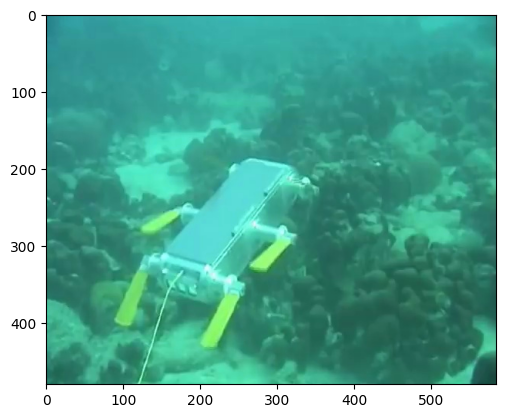

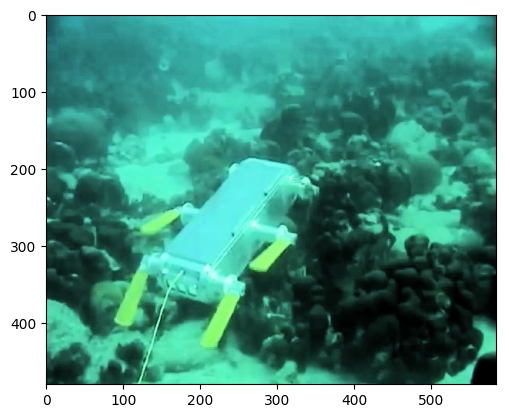

In [28]:

# Example usage:
# Load an image
image =cv2.imread('../images/d_r_160_.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
h,s,v=cv2.split(image)

# Apply adaptive histogram equalization
result_image = clahe(v,clip_limit=5,tile_size=v.shape[1])
corrected_image=cv2.merge([h,s,result_image])

# Display the original and equalized images
# cv2.imshow('Original Image', image)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_HSV2RGB))
plt.show()
# cv2.imshow('Equalized Image', result_image)
plt.imshow(cv2.cvtColor(corrected_image,cv2.COLOR_HSV2RGB))
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [25]:
image=cv2.imread('../images/d_r_160_.jpg')
img=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
h,s,v=cv2.split(img)
mask=cv2.createCLAHE(5,[10,10])
v=mask.apply(v)
img=cv2.merge([h,s,v])
img=cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
arr=np.random.randint(0,255,size=5000)

In [9]:
hist,bins=np.histogram(arr,bins=255)

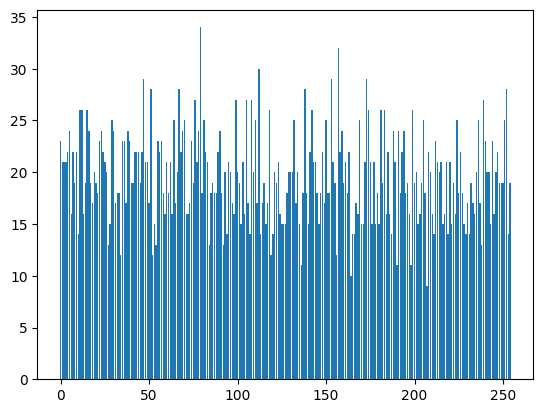

In [10]:
plt.bar(np.arange(255),hist)
plt.show()

In [11]:
pdf=hist/hist.sum()

In [12]:
cdf=pdf.cumsum()

In [13]:
adjusted=cdf*255

In [14]:
adjusted=np.round(adjusted)
print(adjusted)

[  1.   2.   3.   4.   6.   7.   8.   9.  10.  11.  11.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  29.  29.
  30.  32.  33.  34.  35.  35.  36.  37.  38.  39.  40.  42.  43.  44.
  45.  46.  47.  48.  49.  51.  52.  53.  54.  55.  56.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  83.  84.  85.  87.  88.  89.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 118. 118. 119. 120. 121. 122. 123. 124. 124. 125. 126. 128. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 139. 140. 141. 142.
 143. 144. 146. 147. 148. 149. 149. 150. 151. 152. 154. 154. 155. 157.
 158. 159. 160. 161. 162. 164. 164. 166. 166. 168. 168. 169. 170. 170.
 171. 172. 173. 174. 175. 177. 178. 179. 180. 181. 182. 182. 183. 185.
 186. 187. 188. 189. 190. 190. 192. 193. 193. 194. 195. 196. 198. 199.
 200. 

In [15]:
arr_adjusted=np.interp(arr,bins[:-1],adjusted)

In [16]:
hist2,bins2=np.histogram(arr_adjusted.astype(np.uint8))

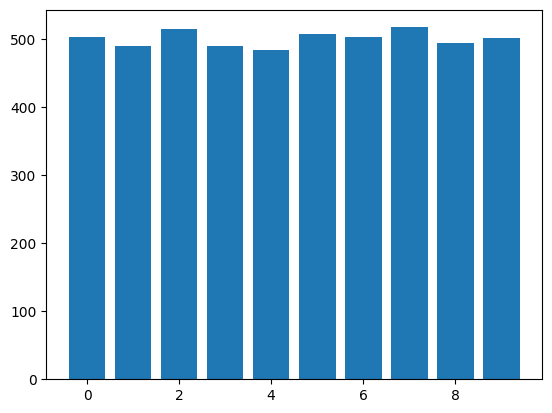

In [17]:
plt.bar(range(len(hist2)),hist2)
plt.show()

In [18]:
tan_arr=np.tan(arr)

In [19]:
tan_hist,tan_bins=np.histogram(tan_arr,bins=255)

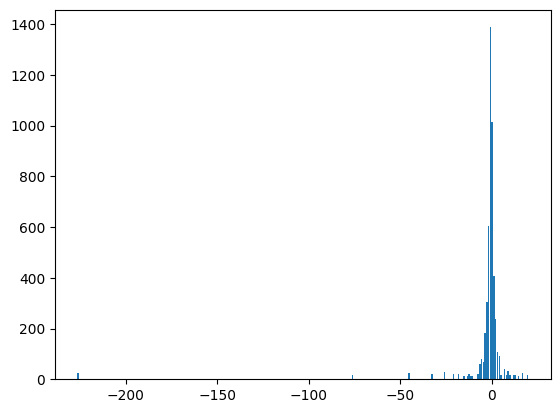

In [20]:
plt.bar(tan_bins[:-1],tan_hist)
plt.show()

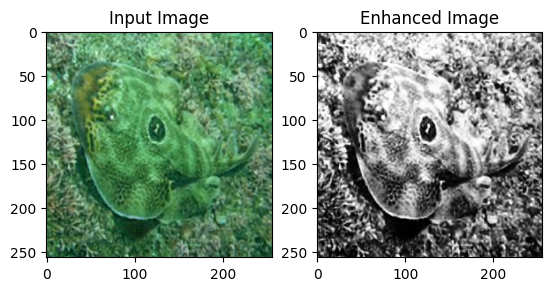

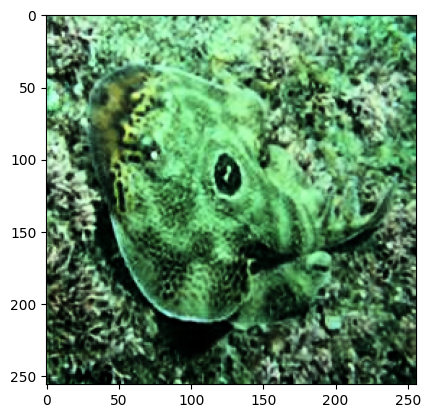

In [29]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import exposure,io,color

# Sample input image
I = io.imread("../images/test1.jpg")
img=color.rgb2hsv(I)
h,s,v=img[:,:,0],img[:,:,1],img[:,:,2]

# 1. Apply arctangent
I_atan = np.arctan(v)

# 2. Calculate weighted histogram 
hist, bins = np.histogram(I_atan.flatten(), bins=256, density=True) 
cdf = hist.cumsum() # cdf
cdf /= cdf[-1] # normalize cdf

# 3. Define desired CDF for mapping
t = np.linspace(15,230,230-15)
st = np.arctan(t-15)
cdf_desired = st.cumsum()/st.sum() 

# 4. Use histogram equalization to match CDFs 
I_enhanced = exposure.equalize_hist(I_atan, cdf_desired)

# Display results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(I, cmap='gray')
ax2.imshow(I_enhanced, cmap='gray')
ax1.set_title('Input Image')
ax2.set_title('Enhanced Image')
plt.show()
enhanced_image=np.zeros(shape=I.shape)
enhanced_image[:,:,0],enhanced_image[:,:,1],enhanced_image[:,:,2]=h,s,I_enhanced
enhanced_image=color.hsv2rgb(enhanced_image)
plt.imshow(enhanced_image)
plt.show()